# Credit Card Default Prediction using Machine learning techniques

## **Business Context**

### Banks are primarily known for money lending business. The more money they lend to people whom they can get good interest with timely repayment, the more revenue is for the banks.

###  The more banks are able to identify borrowers going towards serious delinquency rate, the better will be the bank's money lending business which in turn will lead to better revenue and better image in the market and with respect to competitiors. 

***

## **Objective** : 

### Building a model using the inputs/attributes which are general profile and historical records of a borrower to predict whether one is likely to have serious delinquency in the next 2 years 

### Terms
*  **Delinquent** in general is a slightly mild term where a borrower is not repaying charges and is behind by certain months whereas 
* **Default** is a term where a borrower has not been able to pay charges and is behind for a long period of months and is unlikely to repay the charges.
* **

* We have a general profile about the borrower such as age, Monthly Income, Dependents and the historical data such as what is the Debt Ratio, what ratio of amount is owed wrt credit limit, and the no of times defaulted in the past one, two, three months.
* We will be using all these features to predict whether the borrower is likely to delinquent in the next 2 years or not.
* These kind of predictions will help banks to take necessary actions.


In [3]:
# !pip install pandas==1.3.0
# !pip install numpy==1.18.5
# !pip install imbalanced_learn==0.8.0
# !pip install scipy==1.7.0
# !pip install lightgbm==3.3.0
# !pip install imblearn==0.0
# !pip install scikit_learn==1.0.2
# !pip install lime==0.2.0.1
# !pip install shap==0.40.0

# **Importing libraries**

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import math

from scipy.stats import kurtosis
from scipy import stats, special
from scipy.stats import skew

import shap
from lime.lime_tabular import LimeTabularExplainer

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

In [2]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

In [3]:
# Display all rows and columns of a dataframe
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 1000)

In [4]:
# Importing ML algorithms
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score, precision_score, f1_score,roc_auc_score,auc,roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [5]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Read Preprocessed Data

In [7]:
new_train = pd.read_csv('Data/new_train.csv')


new_test = pd.read_csv('Data/new_test.csv')

new_train.shape, new_test.shape

((119550, 21), (29949, 21))

In [8]:
print("Check Event Rate for Target feature in both Train and Test datset")
print(new_train['SeriousDlqin2yrs'].sum()/len(new_train))
print()
print(new_test['SeriousDlqin2yrs'].sum()/len(new_test))

Check Event Rate for Target feature in both Train and Test datset
0.06693433709744877

0.06694714347724465


## **Tackling Class Imbalance Problem using:**

    * Upsampling the minority class (default rate)
    * Downsampling the majority class (non defaulters)
    * SMOTE - synthethic sampling
    
    
Upsampling in machine learning is a technique used to address class imbalance in a dataset. Class imbalance occurs when the number of instances in one class is significantly lower than the number of instances in another class. This can be problematic because most machine learning algorithms are designed to maximize overall accuracy, and may therefore struggle to correctly classify instances from the minority class.

Upsampling involves increasing the number of instances in the minority class by generating synthetic data points that are similar to the existing data points. One common upsampling technique is called SMOTE (Synthetic Minority Over-sampling Technique), which works by generating synthetic instances of the minority class by interpolating between existing instances.

Upsampling can be used in conjunction with other techniques such as downsampling (reducing the number of instances in the majority class) or using weighted loss functions to further improve the performance of machine learning models on imbalanced datasets. However, it is important to note that upsampling can also lead to overfitting if not used carefully, and it is always best to validate the results of any upsampling technique on a held-out test set.

In [9]:
# drop CustomerID column from both train and test
df_train = new_train.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_train = new_train['SeriousDlqin2yrs']

df_test = new_test.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_test = new_test['SeriousDlqin2yrs']

### Upsampling

In [10]:
df_majority = new_train[new_train['SeriousDlqin2yrs']==0]
df_minority = new_train[new_train['SeriousDlqin2yrs']==1]

df_majority.shape, df_minority.shape

((111548, 21), (8002, 21))

In [11]:
# replacing the samples keeping 100000 as the defaulters to keep in line with the non defaulters

df_minority_upsampled = resample(df_minority, replace=True, n_samples=100000, random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled['SeriousDlqin2yrs'].value_counts()

0    111548
1    100000
Name: SeriousDlqin2yrs, dtype: int64

In [12]:
df_minority_upsampled['SeriousDlqin2yrs'].value_counts()

1    100000
Name: SeriousDlqin2yrs, dtype: int64

In [13]:
df_upsampled.shape

(211548, 21)

In [14]:
y_train_upsampled = df_upsampled['SeriousDlqin2yrs']

df_upsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], axis=1, inplace=True)

df_upsampled.shape, y_train_upsampled.shape,

((211548, 19), (211548,))

### Downsampling

In [15]:
new_train['SeriousDlqin2yrs'].value_counts()

0    111548
1      8002
Name: SeriousDlqin2yrs, dtype: int64

In [16]:
# keeping 8000 as  non defaulters to keep in line with the defaulters

df_majority_downsampled = resample(df_majority, n_samples=8000, random_state=42)
df_downsampled = pd.concat([df_minority,df_majority_downsampled])

df_downsampled['SeriousDlqin2yrs'].value_counts()

1    8002
0    8000
Name: SeriousDlqin2yrs, dtype: int64

In [17]:
y_train_downsampled = df_downsampled['SeriousDlqin2yrs']

df_downsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1, inplace=True)

df_downsampled.shape,  y_train_downsampled.shape


((16002, 19), (16002,))

In [18]:
df_test.shape, y_test.shape

((29949, 19), (29949,))

### SMOTE

- Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input.

In [19]:
# sampling_strategy: The number of samples in the different classes will be equalized
# 'minority': resample only the minority class
# k_neighborsint: nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples

smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 2, random_state=42)

os_data_X, os_data_y = smote.fit_resample(df_train, y_train)

In [20]:
os_data_y.shape

(223096,)

In [21]:
os_data_X.shape, sum(os_data_y)/len(os_data_y)

((223096, 19), 0.5)

In [22]:
os_data_X.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

* Now the event rate in the training dataset is 50%

In [23]:
# Making a copy of the dataframes so that tarnsformed df and original df is separate to comapre results

os_data_X_tranformed  = os_data_X.copy()
df_test_transformed   = df_test.copy()

In [24]:
df_test_standaradized = df_test.copy()

In [25]:
df_downsampled_transformed = df_downsampled.copy()
df_upsampled_transformed   = df_upsampled.copy()

## features Scaling

Feature scaling is a data preprocessing technique used in machine learning to normalize the range of features or variables in a dataset. Feature scaling can help to improve the performance of machine learning algorithms by reducing the impact of the different scales of features in the dataset.

In many machine learning models, features that have larger values can have a greater impact on the model's performance. However, this may not always be desirable, especially if the features are not equally important. Therefore, feature scaling is used to bring all features to a similar range.

### Two common methods of feature scaling are:

#### Min-max scaling: In this method, the values of each feature are scaled to a fixed range between 0 and 1. The formula for min-max scaling is:

X_scaled = (X - X_min) / (X_max - X_min)

#### Standardization: In this method, the values of each feature are scaled to have a mean of 0 and a standard deviation of 1. The formula for standardization is:

X_scaled = (X - X_mean) / X_std

Feature scaling can be applied to both continuous and categorical features in a dataset. However, categorical features are usually converted to numerical values using one-hot encoding or label encoding before feature scaling.

It is important to note that feature scaling should be applied only after data splitting to avoid data leakage. Data leakage is a situation where information from the test set leaks into the training set, leading to an over-optimistic evaluation of the model's performance.

* **Scaling of the features so convergence of the model towards global minima can be achieved and training can be done faster**
* We will be using a couple of Feature Transformation techniques:
* **
    * BoxCox Transformations
    * Standaradization
        

Box-Cox transformation is a data preprocessing technique used in machine learning to transform non-normal distributed data to a more normal distribution. The transformation is performed using a parameter lambda (λ) that is estimated from the data.

The Box-Cox transformation is defined as:

y(lambda) = (y^lambda - 1) / lambda for lambda != 0
log(y) for lambda = 0

where y is the original data, and y(lambda) is the transformed data.

The Box-Cox transformation is useful when the data is skewed or does not follow a normal distribution. By transforming the data to a normal distribution, it can improve the performance of many machine learning algorithms that assume normality, such as linear regression.

The parameter lambda is estimated using maximum likelihood estimation. The value of lambda that maximizes the likelihood function is chosen as the optimal value. The range of lambda values to consider can be specified, or it can be searched over using a grid search or optimization algorithm.

It is important to note that Box-Cox transformation should be applied only on the training set and then applied to the validation and test sets to avoid data leakage. Additionally, it may not always be necessary to apply Box-Cox transformation, and it should be validated using cross-validation or a held-out test set.

* We will check with how skewness changes after the transformations 
* And we will check on SMOTE sampling technique dataset
* follow data Transformation done on SMOTE sampling technique dataset

#### Scaling features using BoxCox Transformations
- Box-Cox transformation is a statistical technique that transforms your target variable so that your data closely resembles a normal distribution.
- Transformation improve predictive power of model

In [26]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()

In [27]:
# check skewness of Smote sampling technique dataset
SkewMeasure(os_data_X_tranformed)

skew
MonthlyIncome                         150.440824
MonthlyIncomePerPerson                111.019404
MonthlyDebt                           104.775409
DebtRatio                             103.291924
NumberOfTime60-89DaysPastDueNotWorse    8.754920
NumberOfTimes90DaysLate                 8.257623
CombinedPastDue                         8.249275
NumberOfTime30-59DaysPastDueNotWorse    5.156716
NumberRealEstateLoansOrLines            3.764830
isRetired                               2.556428
NumberOfDependents                      1.411704
hasMultipleRealEstates                  1.348802
RevolvingLines                          1.275259
CombinedCreditLoans                     1.115111
NumberOfOpenCreditLinesAndLoans         1.108340
RevolvingUtilizationOfUnsecuredLines    0.747770
hasRevolvingLines                      -4.125332

In [28]:
skewM = SkewMeasure(os_data_X_tranformed)

# lambda is parameter of boxcox1p() function which transform to normal distribution
# set lambda to 0.15 else value can be choose by scipy

for i in skewM.index:
    os_data_X_tranformed[i] = special.boxcox1p(os_data_X_tranformed[i], 0.15) #lambda = 0.15
    df_test_transformed[i]  = special.boxcox1p(df_test_transformed[i], 0.15) #lambda = 0.15
SkewMeasure(os_data_X_tranformed)

skew
NumberOfTime60-89DaysPastDueNotWorse  4.644356
NumberOfTimes90DaysLate               3.765458
isRetired                             2.556428
NumberOfTime30-59DaysPastDueNotWorse  2.103570
DebtRatio                             2.103448
MonthlyDebt                           1.921552
CombinedPastDue                       1.857797
hasMultipleRealEstates                1.348802
NumberOfDependents                    0.788863
NumberRealEstateLoansOrLines          0.668400
NumberOfOpenCreditLinesAndLoans      -0.572554
CombinedCreditLoans                  -0.616644
MonthlyIncomePerPerson               -1.287085
MonthlyIncome                        -1.970267
hasRevolvingLines                    -4.125332

* After apply Feature scaling technique BoxCox transformation Skewness is reduce
* and all feature are near to normal distribution

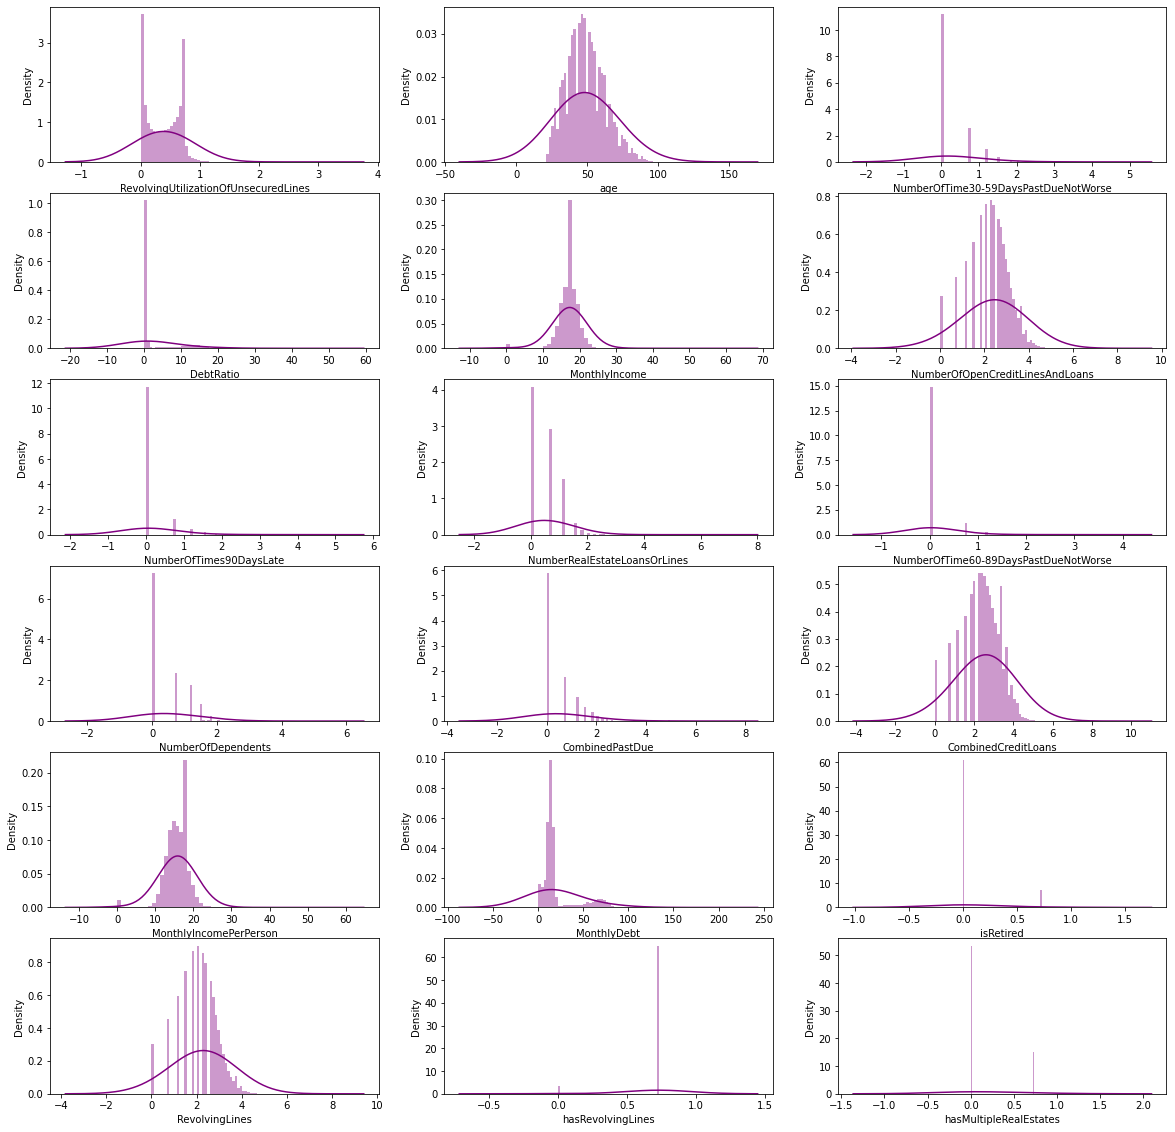

In [32]:
# After apply Feature scaling technique BoxCox transformation Skewness is reduce check plots
columnList = list(df_test_transformed.columns)

fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(os_data_X_tranformed[col], ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

* Skewness is reduced and now the graphs are looking good as Normal Distribution.

In [29]:
# df_train_transformed original shape dataset 
# only perform feature scaling using boxcox1p() and same lambda as use for smote case i.e. 0.15

df_train_transformed = df_train.copy()
print(df_train_transformed.shape)

skewM = SkewMeasure(df_train)

for i in skewM.index:
    df_train_transformed[i] = special.boxcox1p(df_train_transformed[i],0.15) #lambda = 0.15

(119550, 19)


In [30]:
df_train_transformed.shape

(119550, 19)

#### Standardization
##### Scaling features using Standardization Transformations

- each value subtract from mean and divided by standard deviation
- Standardization is used for feature scaling when your data follows Gaussian distribution
- It is most useful for: Optimizing algorithms such as gradient descent. Clustering models or distance-based classifiers like K-Nearest Neighbors.

 * Data Transformation by Standardization on SMOTE sampling technique dataset

In [31]:
# use Balance data from SMOTE technique which is os_data_X for StandardScalar

scaler = StandardScaler().fit(os_data_X)

X_train_scaled = scaler.transform(os_data_X) # for train 
X_test_scaled = scaler.transform(df_test)    # for test

In [32]:
# use Balance data from Upsampling technique which is df_upsampled_transformed for StandardScalar

scaler = StandardScaler().fit(df_upsampled_transformed)

X_train_scaled_upsampled = scaler.transform(df_upsampled_transformed) 
X_test_scaled_upsampled = scaler.transform(df_test_standaradized)

In [33]:
# use Balance data from Downsampling technique which is df_downsampled_transformed for StandardScalar

scaler = StandardScaler().fit(df_downsampled_transformed)

X_train_scaled_downsampled = scaler.transform(df_downsampled_transformed) 
X_test_scaled_downsampled = scaler.transform(df_test_standaradized)

- df_train_transformed: Box Cox transformed dataset Train
- df_train_transformed: Box Cox transformed dataset Test

- X_train_scaled: with SMOTE technique And StandardScalar Train
- X_test_scaled: with SMOTE technique And StandardScalar Test 


- X_train_scaled_upsampled: with Upsample technique And StandardScalar Train
- X_test_scaled_upsampled:  with Upsample technique And StandardScalar Test


- X_train_scaled_downsampled: with Downsample technique And StandardScalar Train
- X_test_scaled_downsampled: with Downsample technique And StandardScalar Train

- os_data_X_tranformed: with SMOTE technique balanced Dataset X_Train
- os_data_y: with SMOTE technique balanced Dataset Y_train
- df_test: test data

# ML Modeling

**Training the model :**

* We will be training the model using different algorithms 
* We wil also be comparing the results using transformed dataset and the original dataset
* We will check and compare on which algorithms transformations works and on which not.
* We will be doing Cross Validation and will see if the model performance is fluctuating using the statistical measures such as mean and standarad deviation 

* **
* **Predicting the customers from the test dataset and comapring with the true values from the test dataset using different evaluation metrics will give us which model to go for and which model is performing the best**

* **
* **We will also be evaluating our model on different metrics and why some metrics might fail in our case study which is one of the most popular metric to evaluate a model performance**

* **
* **Some common evaluation metric you will be seeing across all modeling algorithms are:**
    * **Precision** - **How good a model is in predicting the events**
        * True Positive/(True Positive + False Positives)
    * **Recall** - **How good a model is able to capture relevant events(Coverage)**
        * True Positive/(True Positive + False Negatives)
    * **F1 Score** - **Harmonic mean between Precision and Recall, this metric penalized either one of the lower scorer metric so that trade off can be maintained**
    * **Area Under the Curve & ROC** - **how good a model is able to differentiate between the classes**
        * It is plotted as False Positive Rate on the x-axis and True Positive Rate on the y-axis  using different thresholds.
        * The more the area or the line it is above straight diagonal line, the better is model performance as comapred to randomly predicting the classes
        
* **
* **We will be comapring the different modeling techniques AUC results to see which ones are performing better as compared to others**
* **
* **We will be tuning hyper parameters of the models to achieve better results and see how tuning increases performance if it does**
* **Training Original dataset with using hyperparameter which is balancing minority class as per the majority class**

* macro: equal importance of majority and minority class
* micro: score usally gives importance for majority of class
* check macro and micro for each matrics Precision, Recall, f1_score

# Neural Network

In [34]:
# custom metrics (in Keras no have default function)
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [35]:
# architecture of neural network

def fit_model(data, labels, test_data,test_label, epochs, batch_size):
    
    n_inputs = data.shape[1]
    model    = keras.Sequential()
    model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1,activation ='sigmoid'))
    
    model_file_name = 'MLP_predict_default_case_study.hdf5'
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_recall", mode="max", patience=15)

    model.compile(optimizer = 'adam',
                 loss= 'binary_crossentropy',
                 metrics = [precision,recall])
    
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       validation_data=(test_data,test_label))
    
    return model

In [36]:
def compute_precisions_thresolds(data, labels, test_data, test_label, epochs, batch_size):
    
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)
    y_test_pred   = trained_model.predict(test_data)
    
    P_macro = [] ; P_micro = [];  R_macro = [] ;R_micro = []; F1_macro = [] ;F1_micro = []; cut_off = [] ; metrics = pd.DataFrame()
    threshold_list = [0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96]
    
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el>thres else 0 for el in y_test_pred]
        
        prec_macro      = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='macro'),2)
        P_macro.append(prec_macro)
        
        prec_micro      = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='micro'),2)
        P_micro.append(prec_micro)
        
        rec_macro       = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='macro'),2)
        R_macro.append(rec_macro)
        
        rec_micro       = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='micro'),2)
        R_micro.append(rec_micro)
        
        f1_macro        = round(f1_score(test_label, y_test_pred_new, average='macro'),2)
        F1_macro.append(f1_macro)
        
        f1_micro        = round(f1_score(test_label, y_test_pred_new, average='micro'),2)
        F1_micro.append(f1_micro)
        
    metrics = pd.DataFrame({'Threshold' : cut_off, 'Precision Macro' : P_macro,\
                            'Precision Micro' : P_micro,'Recall Macro' : R_macro,\
                            'Recall Micro' : R_micro,'F1 Score Macro' : F1_macro,\
                            'F1 Score Micro' : F1_micro})
    
    return metrics.sort_values(by=['Threshold'], ascending=False)

## In class imbalanced problem, macro and micro important
* macro: equal importance of majority and minority class
* micro: score usally gives importance for majority of class
* check macro and micro for each matrics Precision, Recall, f1_score

### in this problem we focus on Macro for all metrics

* **Appling Neural Network model on Box Cox transformed dataset**

In [41]:
box_cox_metrics = compute_precisions_thresolds(os_data_X_tranformed, os_data_y,\
                                               df_test_transformed,\
                                               y_test, epochs=15,\
                                               batch_size=128)

Epoch 1/15
1743/1743 [==============================] - 3s 1ms/step - loss: 0.6451 - precision: 0.6942 - recall: 0.6868 - val_loss: 0.5517 - val_precision: 0.1680 - val_recall: 0.8268
Epoch 2/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4728 - precision: 0.7684 - recall: 0.7992 - val_loss: 0.4218 - val_precision: 0.2002 - val_recall: 0.7456
Epoch 3/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4511 - precision: 0.7802 - recall: 0.8047 - val_loss: 0.4340 - val_precision: 0.2004 - val_recall: 0.7516
Epoch 4/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4385 - precision: 0.7829 - recall: 0.8106 - val_loss: 0.3721 - val_precision: 0.2202 - val_recall: 0.6750
Epoch 5/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4303 - precision: 0.7811 - recall: 0.8195 - val_loss: 0.4094 - val_precision: 0.1964 - val_recall: 0.7410
Epoch 6/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.42

In [42]:
box_cox_metrics_nn = box_cox_metrics.copy()
box_cox_metrics_nn.reset_index(drop=True)

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
0       0.96             0.70             0.93          0.50          0.93   
1       0.95             0.69             0.93          0.50          0.93   
2       0.90             0.72             0.93          0.52          0.93   
3       0.80             0.71             0.93          0.59          0.93   
4       0.70             0.66             0.91          0.68          0.91   
5       0.60             0.61             0.86          0.74          0.86   
6       0.50             0.59             0.78          0.76          0.78   
7       0.40             0.57             0.71          0.76          0.71   
8       0.30             0.56             0.63          0.74          0.63   
9       0.25             0.56             0.59          0.73          0.59   

   F1 Score Macro  F1 Score Micro  
0            0.49            0.93  
1            0.49            0.93  
2            0.51            0.93  
3            0.62            0.93  
4            0.67            0.91  
5            0.64            0.86  
6            0.59            0.78  
7            0.55            0.71  
8            0.50            0.63  
9            0.47            0.59

- When check pattern in evaluation table after apply Neural Network with Box Cox Transform data,
- In increasing threshold, BALANCE between the Precision Macro will increase (event trade for Positive class) and Recall Macro 
- so check in F1 Score, and good trade of between Precision And Recall score

* **Applying Neural Network on Standardized dataset**

In [43]:
standardized_metrics = compute_precisions_thresolds(X_train_scaled, os_data_y,\
                                                    X_test_scaled, y_test,\
                                                    epochs=15,\
                                                    batch_size=128)

Epoch 1/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4795 - precision: 0.7622 - recall: 0.8113 - val_loss: 0.4082 - val_precision: 0.2010 - val_recall: 0.7493
Epoch 2/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4045 - precision: 0.8045 - recall: 0.8348 - val_loss: 0.3476 - val_precision: 0.2456 - val_recall: 0.6298
Epoch 3/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.3529 - precision: 0.8379 - recall: 0.8278 - val_loss: 0.3418 - val_precision: 0.2367 - val_recall: 0.6706
Epoch 4/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.3398 - precision: 0.8468 - recall: 0.8258 - val_loss: 0.3151 - val_precision: 0.2556 - val_recall: 0.6333
Epoch 5/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.3347 - precision: 0.8492 - recall: 0.8265 - val_loss: 0.3384 - val_precision: 0.2380 - val_recall: 0.6656
Epoch 6/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.33

In [44]:
standardized_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.59             0.93          0.50          0.93   
8       0.95             0.59             0.93          0.50          0.93   
7       0.90             0.72             0.93          0.51          0.93   
6       0.80             0.69             0.93          0.51          0.93   
5       0.70             0.68             0.92          0.62          0.92   
4       0.60             0.64             0.90          0.72          0.90   
3       0.50             0.61             0.84          0.76          0.84   
2       0.40             0.59             0.79          0.77          0.79   
1       0.30             0.58             0.73          0.77          0.73   
0       0.25             0.57             0.70          0.76          0.70   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.50            0.93  
6            0.51            0.93  
5            0.64            0.92  
4            0.67            0.90  
3            0.63            0.84  
2            0.60            0.79  
1            0.56            0.73  
0            0.54            0.70

- F1 score macro max at 0.70 that is 0.68
- compare standardization and box cox transformation on SMOTE technique

* **Applying Neural Network on Original Standaradized dataset**

In [45]:
scaler = StandardScaler().fit(df_train)

df_train_scaled = scaler.transform(df_train) 
df_test_scaled = scaler.transform(df_test)

In [46]:
base_metrics = compute_precisions_thresolds(df_train_scaled, y_train,\
                                            df_test_scaled, y_test,\
                                            epochs=10,\
                                            batch_size=128)

Epoch 1/10
934/934 [==============================] - 2s 1ms/step - loss: 0.2360 - precision: 0.3061 - recall: 0.0664 - val_loss: 0.1828 - val_precision: 0.0171 - val_recall: 0.0015
Epoch 2/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1930 - precision: 0.3102 - recall: 0.0518 - val_loss: 0.1805 - val_precision: 0.3155 - val_recall: 0.0439
Epoch 3/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1892 - precision: 0.3764 - recall: 0.0666 - val_loss: 0.1798 - val_precision: 0.2464 - val_recall: 0.0314
Epoch 4/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1876 - precision: 0.3741 - recall: 0.0710 - val_loss: 0.1795 - val_precision: 0.2735 - val_recall: 0.0387
Epoch 5/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1869 - precision: 0.3987 - recall: 0.0762 - val_loss: 0.1789 - val_precision: 0.4480 - val_recall: 0.0750
Epoch 6/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1860 - precisi

In [47]:
base_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.47             0.93          0.50          0.93   
7       0.90             0.47             0.93          0.50          0.93   
6       0.80             0.47             0.93          0.50          0.93   
5       0.70             0.72             0.93          0.50          0.93   
4       0.60             0.81             0.93          0.50          0.93   
3       0.50             0.79             0.94          0.56          0.94   
2       0.40             0.75             0.94          0.62          0.94   
1       0.30             0.71             0.93          0.68          0.93   
0       0.25             0.69             0.92          0.71          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.48            0.93  
4            0.49            0.93  
3            0.58            0.94  
2            0.66            0.94  
1            0.69            0.93  
0            0.70            0.92

- max F1 score at leat threshold on original standardized Dataset
---

* **Applying Neural Network on Upsampled dataset**

In [48]:
upsampled_metrics = compute_precisions_thresolds(X_train_scaled_upsampled, y_train_upsampled,\
                                                 df_test_standaradized, y_test,\
                                                 epochs=10,\
                                                 batch_size=128)

Epoch 1/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.5141 - precision: 0.7631 - recall: 0.7099 - val_loss: 25573.6816 - val_precision: 0.0345 - val_recall: 0.0057
Epoch 2/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4831 - precision: 0.7780 - recall: 0.7403 - val_loss: 27387.7793 - val_precision: 0.0485 - val_recall: 0.0294
Epoch 3/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4773 - precision: 0.7783 - recall: 0.7458 - val_loss: 27152.6230 - val_precision: 0.0465 - val_recall: 0.0937
Epoch 4/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4746 - precision: 0.7804 - recall: 0.7468 - val_loss: 31223.7949 - val_precision: 0.0303 - val_recall: 0.0051
Epoch 5/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4730 - precision: 0.7802 - recall: 0.7493 - val_loss: 24008.7578 - val_precision: 0.0303 - val_recall: 0.0051
Epoch 6/10
1653/1653 [==============================] - 2s 1

In [49]:
upsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.49             0.93           0.5          0.93   
8       0.95             0.49             0.93           0.5          0.93   
7       0.90             0.49             0.93           0.5          0.93   
6       0.80             0.49             0.93           0.5          0.93   
5       0.70             0.49             0.93           0.5          0.93   
4       0.60             0.49             0.93           0.5          0.93   
3       0.50             0.49             0.93           0.5          0.93   
2       0.40             0.49             0.93           0.5          0.93   
1       0.30             0.49             0.93           0.5          0.93   
0       0.25             0.49             0.92           0.5          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.49            0.93  
8            0.49            0.93  
7            0.49            0.93  
6            0.49            0.93  
5            0.49            0.93  
4            0.49            0.93  
3            0.49            0.93  
2            0.49            0.93  
1            0.49            0.93  
0            0.49            0.92

* **Applying Neural Network on Downsampled dataset**

In [50]:
downsampled_metrics = compute_precisions_thresolds(X_train_scaled_downsampled, y_train_downsampled,\
                                                   df_test_standaradized, y_test,\
                                                   epochs=10,\
                                                   batch_size=128)

Epoch 1/10
126/126 [==============================] - 1s 3ms/step - loss: 0.6414 - precision: 0.6335 - recall: 0.5856 - val_loss: 2825.2759 - val_precision: 0.0751 - val_recall: 0.5998
Epoch 2/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5548 - precision: 0.7372 - recall: 0.7304 - val_loss: 2420.0576 - val_precision: 0.0681 - val_recall: 0.6993
Epoch 3/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5370 - precision: 0.7521 - recall: 0.7532 - val_loss: 5256.8770 - val_precision: 0.0684 - val_recall: 0.6840
Epoch 4/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5258 - precision: 0.7660 - recall: 0.7486 - val_loss: 5661.4424 - val_precision: 0.0686 - val_recall: 0.6936
Epoch 5/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5155 - precision: 0.7626 - recall: 0.7610 - val_loss: 5471.8091 - val_precision: 0.0689 - val_recall: 0.6677
Epoch 6/10
126/126 [==============================] - 0s 2ms/step - loss: 0

In [51]:
downsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.51             0.56          0.54          0.56   
8       0.95             0.51             0.56          0.54          0.56   
7       0.90             0.51             0.56          0.54          0.56   
6       0.80             0.51             0.56          0.54          0.56   
5       0.70             0.51             0.55          0.54          0.55   
4       0.60             0.51             0.55          0.54          0.55   
3       0.50             0.51             0.55          0.54          0.55   
2       0.40             0.51             0.55          0.54          0.55   
1       0.30             0.51             0.55          0.54          0.55   
0       0.25             0.51             0.55          0.54          0.55   

   F1 Score Macro  F1 Score Micro  
9            0.42            0.56  
8            0.42            0.56  
7            0.42            0.56  
6            0.42            0.56  
5            0.42            0.55  
4            0.42            0.55  
3            0.42            0.55  
2            0.42            0.55  
1            0.42            0.55  
0            0.41            0.55

- In Upsample and downsample, there is no significant change in Precision, Recall and F1 score 
- so there is no additional data added in dataset while upsampling or downsampling ( only majority/minirity class change)
- So Neural Network works very BAD

* **It can be cleary seen that Deep learning models require scaling of the features so that error can be minimised when features are nearly of the same scale so that bakcpropogation of errors can be there which results in better optimization**
* **
* **No effect on Neural Network Models whether samples are downsampled or upsampled** but that is not the case when synthetic sampling is used
* **
* Results are more or less the same using Box Cox transformations and Standaradization 

# ML models

**Training the model and predicting on unseen dataset:**

- In total 4 modeling techniques are used - 
    - **Logistic Regression**
    - **Random Forest**
    - **XGBoost**
    - **Light GBM**
***
* Metrics will be calculated using each modeling technique
* Confusion Matrix numbers are TN, FP, FN, TP
* **
   * **A joint plot of ROC AUC will be made to see the performance of classifiers**

In [37]:
def cal_score(y_test, y_pred): 
    cm              = confusion_matrix(y_test, y_pred)
    prec_scr_macro  = precision_score(y_test, y_pred, average='macro')*100
    prec_scr_micro  = precision_score(y_test, y_pred, average='micro')*100
    rec_scr_macro   = recall_score(y_test ,y_pred, average='macro')*100
    rec_scr_micro   = recall_score(y_test ,y_pred, average='micro')*100
    f1_scr_macro    = f1_score(y_test, y_pred, average='macro')*100 
    f1_scr_micro    = f1_score(y_test, y_pred, average='micro')*100 
    
    return prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm

In [38]:
# cross_val_score matrix first time used for case study,
# record the accuracy and standard deviation for 5 different cross val score
# if cross _val_score the standard deviation is less side then model is not deviating and performance consistant..
# and mean_accuarcy of all 5 cross validation score...

def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision Macro', 'Precision Micro', 'Recall Macro','Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    
    crs_val     = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val),3)
    std_acc  = round(np.std(crs_val),3)
    
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)
    
    prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm = cal_score(testing_label, predictions)
    result.extend([mean_acc,std_acc, prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)
    
    return series_result


In [39]:
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Light GBM' : LGBMClassifier(random_state=42)
}

## **Logistic Regression** : 

- statistical technique
* **
    * 1/(1+e^-value)
   * **
    * p(x) = e^(b0+b1*X)/(1+e^(b0+b1*X))
    * ln(p(X)/1-p(X)) = b0+b1*X
    
    
### Assumptions behind Logistic Regression
- data should be Normaly distributed

## Tree Based Models

* **Evolution of Tree Based Algorithms and going towards XGboost** -
* **
* **Decision Tree** : ( base of tree based algorithmn) A graphical representation of possible solutions to a decision based on certain conditions.
* **
* **Bagging** : Bootstrap aggregating or Bagging is a ensemble meta-algorithm combining predictions from multiple decision trees through a majority voting mechanism.
* **
* **Random Forest** : Bagging based algorithm where only a subset of features are selected at random to build a forest or collection of decision trees.
* **
* **Boosting** : Models are built sequentially by minizing the errors from previous models while increasing(boosting) influence of high-performing models.
* **
* **Gradient Boosting** : It employs gradient descent algorithm to minimize errors in sequential models.
* **
* **XGBoost** : Optimized Gradient Boosting algorithm through parallel processing, tree-pruning,handling missing values and regularization to avoid overfitting/bias.

* **Frameowrk of Boosting**:
    * F1(x) <- F0(x) + h1(x)
    * F2(x) <- F1(x) + h2(x)
    * Fm(x) <- Fm-1(x) + hm(x)

## **Training Box Cox transformed SMOTE dataset using ML algorithms**

In [55]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], os_data_X_tranformed,\
                                            df_test_transformed, os_data_y, y_test)
    frame[key]    = classifier_result
        
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df

[17:34:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Random Forest  \
Mean Accuracy                              0.933   
Accuracy deviation                         0.018   
Precision Macro                        63.244055   
Precision Micro                        89.398644   
Recall Macro                           69.133576   
Recall Micro                           89.398644   
F1 Score Macro                         65.414847   
F1 Score Micro                         89.398644   
Confusion Matrix    [[25857, 2087], [1088, 917]]   

                                         XGBoost  \
Mean Accuracy                              0.881   
Accuracy deviation                         0.026   
Precision Macro                        60.338045   
Precision Micro                        85.552105   
Recall Macro                           71.169571   
Recall Micro                           85.552105   
F1 Score Macro                          62.73923   
F1 Score Micro                         85.552105   
Confusion Matrix    [[24528, 3416], [911, 1094]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.794                         0.855  
Accuracy deviation                         0.007                         0.017  
Precision Macro                        58.809604                     60.182155  
Precision Micro                        78.753882                     83.027814  
Recall Macro                           75.929427                     75.233583  
Recall Micro                           78.753882                     83.027814  
F1 Score Macro                         59.420567                     62.287239  
F1 Score Micro                         78.753882                     83.027814  
Confusion Matrix    [[22129, 5815], [548, 1457]]  [[23538, 4406], [677, 1328]]

- when the smote data with Box Cox transformation, check Accuracy, Precision, Recall and F1 score
- least Accuracy Deviation means good model performance
- for Logistic Regression:
- Accuracy Deviation is least than other 3 algorithm, so for SMOTE dataset Box Cox Transform Logistic Regression is good model
- RandomForest is overfit model, precision of RandomForest algo is very high than other matrices


---

## **Training Standaradized dataset using ML algorithms**

In [56]:
frame_std = {}
for key in clf_dict:

    classifier_result_std = metrics_calculation(clf_dict[key], X_train_scaled,\
                                                X_test_scaled, os_data_y, y_test)
    frame_std[key]    = classifier_result_std
        
standardized_smote_df = pd.DataFrame(frame_std)
standardized_smote_df

[17:39:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Random Forest  \
Mean Accuracy                              0.934   
Accuracy deviation                         0.018   
Precision Macro                        63.290883   
Precision Micro                        89.391966   
Recall Macro                           69.292036   
Recall Micro                           89.391966   
F1 Score Macro                         65.493193   
F1 Score Micro                         89.391966   
Confusion Matrix    [[25848, 2096], [1081, 924]]   

                                         XGBoost  \
Mean Accuracy                              0.882   
Accuracy deviation                         0.024   
Precision Macro                        60.299683   
Precision Micro                        85.395172   
Recall Macro                           71.363255   
Recall Micro                           85.395172   
F1 Score Macro                         62.690932   
F1 Score Micro                         85.395172   
Confusion Matrix    [[24469, 3475], [899, 1106]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.827                         0.855  
Accuracy deviation                          0.02                         0.018  
Precision Macro                        60.238184                      60.11352  
Precision Micro                         84.55708                     82.927644  
Recall Macro                           72.766011                     75.156755  
Recall Micro                            84.55708                     82.927644  
F1 Score Macro                         62.578749                     62.181112  
F1 Score Micro                          84.55708                     82.927644  
Confusion Matrix    [[24138, 3806], [819, 1186]]  [[23509, 4435], [678, 1327]]

- Standardized Dataset on original Dataset Logistic Regression evaluation matrics givs good results
- And also for 3 Algorithm gives same result on both Box and Standardized, Original and SMOTE dataset

## **Training Original dataset with using hyperparameter**
### **which is balancing minority class as per the majority class**

In [40]:
# Weights associated with classes in the form {class_label: weight}
# class_weight = {0:1, 1:10} in RandomForest and Logistic Regression
# means class 1 have 10 times weight as compare to class 0 (non event rate )

clf_dict_balanced = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight = {0:1, 1:10}),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight = 10),
    'Logistic Regression' : LogisticRegression(random_state=42, class_weight = {0:1, 1:10}),
    'Light GBM' : LGBMClassifier(random_state=42, scale_pos_weight = 10)
}

In [58]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[17:42:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Random Forest                       XGBoost  \
Mean Accuracy                             0.934                         0.865   
Accuracy deviation                        0.001                         0.002   
Precision Macro                       75.825877                     62.018829   
Precision Micro                       93.565728                     85.896023   
Recall Macro                          57.107222                     75.890947   
Recall Micro                          93.565728                     85.896023   
F1 Score Macro                        60.222459                     64.981585   
F1 Score Micro                        93.565728                     85.896023   
Confusion Matrix    [[27721, 223], [1704, 301]]  [[24435, 3509], [715, 1290]]   

                          Logistic Regression                     Light GBM  
Mean Accuracy                            0.93                         0.848  
Accuracy deviation                      0.003                         0.003  
Precision Macro                     49.264699                     61.861708  
Precision Micro                     92.791078                     84.740726  
Recall Macro                        49.932784                     77.980211  
Recall Micro                        92.791078                     84.740726  
F1 Score Macro                       48.54321                     64.703492  
F1 Score Micro                      92.791078                     84.740726  
Confusion Matrix    [[27781, 163], [1996, 9]]  [[23972, 3972], [598, 1407]]

### ** Precision macro is increases when no scale data only use hyperparameter class_weight
### **XGBoost and Light GBM are performing better in terms of Recall & Light GBM whereas Random Forest in Precision**

## **Training Scaled oiginal dataset with using hyperparameter which is balancing minority class as per the majority class**

In [59]:
frame_balanced_scaled= {}
for key in clf_dict_balanced:

    classifier_result_balanced_scaled = metrics_calculation(clf_dict_balanced[key], df_train_transformed, df_test_transformed, y_train, y_test)
    frame_balanced_scaled[key]    = classifier_result_balanced_scaled
        
balanced_df_scaled = pd.DataFrame(frame_balanced_scaled)
balanced_df_scaled

[17:44:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Random Forest                       XGBoost  \
Mean Accuracy                             0.934                         0.864   
Accuracy deviation                        0.001                         0.002   
Precision Macro                       75.783591                     62.308209   
Precision Micro                       93.562389                     86.383519   
Recall Macro                          57.082284                     75.666069   
Recall Micro                          93.562389                     86.383519   
F1 Score Macro                        60.186768                     65.353966   
F1 Score Micro                        93.562389                     86.383519   
Confusion Matrix    [[27721, 223], [1705, 300]]  [[24602, 3342], [736, 1269]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.857                         0.848  
Accuracy deviation                         0.001                         0.003  
Precision Macro                         62.63657                     61.861708  
Precision Micro                        86.386858                     84.740726  
Recall Macro                           76.802128                     77.980211  
Recall Micro                           86.386858                     84.740726  
F1 Score Macro                         65.800699                     64.703492  
F1 Score Micro                         86.386858                     84.740726  
Confusion Matrix    [[24554, 3390], [687, 1318]]  [[23972, 3972], [598, 1407]]


## **Logistic Regression metrics are changed while all other model metrics remain same**
- Logistic Regression: precision and Recall decreases after Hyperparameter in original Dataset
- For Logistic Regression need transform data

## Hence, Logistic Regression algorithm requires scaling of features whereas tree based model doesn't required scaling feature

---

## **Plotting ROC AUC for the ML models for the transformed dataset**

In [41]:
models = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=42)
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(random_state=42)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42)
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(random_state=42)
    }
]

In [42]:
def plot_multiplt_rocauc(models,train_X, train_y ,dev_X, dev_y):
    
    for m in models:
        model = m['model']   
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred   = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]      # index 1 because predict_proba gives True labels (index 0: for 0 class and index 1: for 1 class)
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)   # we have concern with Positive class
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    
    return 

[17:46:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


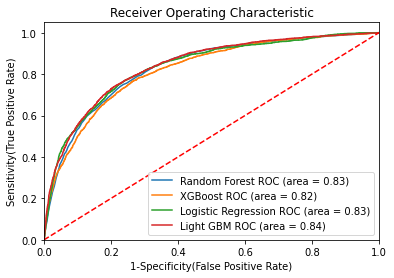

In [62]:
plot_multiplt_rocauc(models,os_data_X_tranformed,os_data_y, df_test_transformed, y_test)

* AUC of all the models are on a similar scale except the XGBoost model which is 0.1 on a higher side

* AUC of XGBoost Light GBM are performing beyeer than the others

## **Key takeaways:**
* **
* Tree Based model doesn't require scaling of the features
* Statistical - Logistic Regression requires scaling of the features
* Upsampling of the Minority Class, Downsampling of the Majority Class and SMOTE sampling results are not better as compared to hyperparamater turning on using class weights in the model itself
    
* **We will be proceeding with the original dataset without scaling of the featues but using class weights in the model itself**
    

## RFECV for Correlated Feature elimination and selecting optimal Feature
### **Feature Importance**
    * We will be plotting top features by importance of all the ML algorithms
    * we will be plotting Logistic Regression features by correlation

In [43]:
def plot_feature_importances(model, data):
    plt.figure(figsize=(8,6))
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

Model is  Random Forest
Model is  XGBoost
Model is  Light GBM


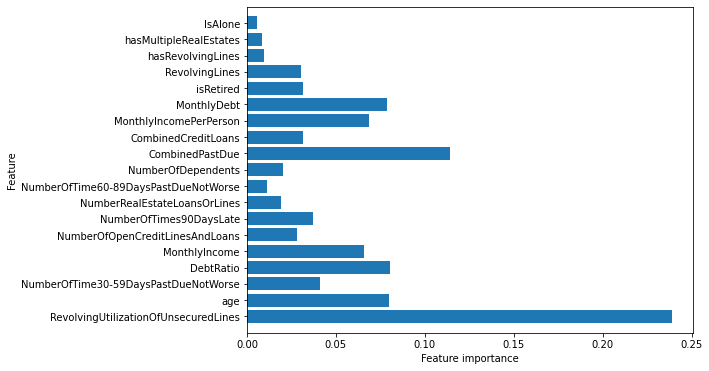

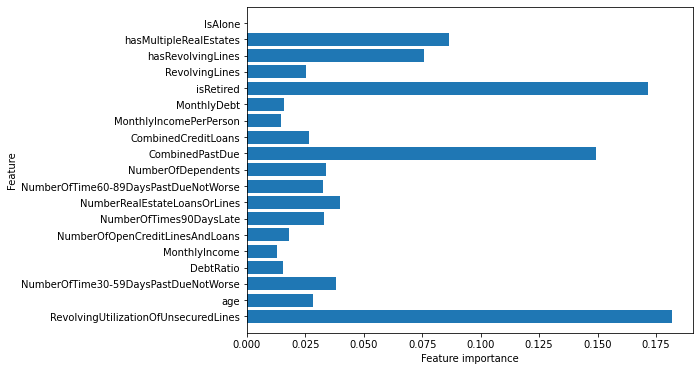

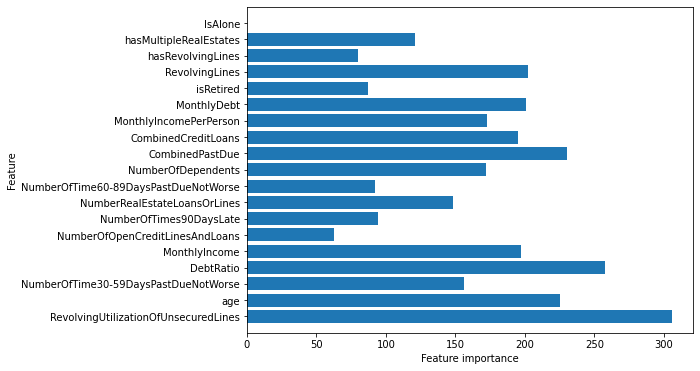

In [64]:
for key in clf_dict.keys():
  if key =='Logistic Regression':
    continue
  else:
    print('Model is ', key)
    plot_feature_importances(clf_dict[key], os_data_X_tranformed)

* In all ML models, ratio of amount owed to the credit limit is the top feature followed by Combined Past Due which is the summation of all dues by a borrower
* **
* In Light GBM model, others features are also contributing to a greater extent
* Light GBM model gives proper and meaningful feature Importance than other three model

### Logistic Regression features Importance by correlation

In [65]:
logreg = LogisticRegression(random_state=42)
logreg.fit(os_data_X_tranformed, os_data_y)

coeff_df = pd.DataFrame(os_data_X_tranformed.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature  Correlation
0   RevolvingUtilizationOfUnsecuredLines     4.268059
10                       CombinedPastDue     3.107923
11                   CombinedCreditLoans     1.446264
12                MonthlyIncomePerPerson     0.434786
5        NumberOfOpenCreditLinesAndLoans     0.241788
9                     NumberOfDependents     0.221908
13                           MonthlyDebt     0.004490
1                                    age     0.001818
3                              DebtRatio    -0.031156
7           NumberRealEstateLoansOrLines    -0.284883
4                          MonthlyIncome    -0.454052
17                hasMultipleRealEstates    -0.790995
6                NumberOfTimes90DaysLate    -1.142692
15                        RevolvingLines    -1.267606
18                               IsAlone    -1.362732
8   NumberOfTime60-89DaysPastDueNotWorse    -1.582678
2   NumberOfTime30-59DaysPastDueNotWorse    -2.008762
16                     hasRevolvingLines    -2.065128
14                             isRetired    -2.806417

- Log odds convert the Logistic Regression which is a probability-based model to a Likelihood–based model. Logistic Regression parameters are determined by Maximum Likelihood Estimation (MLE) They are very useful in solving problems of win or lose, fraud or non-fraud, span not span-like scenarios.
### * Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability)

## Feature Selection using RFECV

* We will be using RFECV on **Random Forest** to remove correlated features because they might be providing the same information

In [66]:
def RFE(model, training_data, training_label):
    rfc = model
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv.fit(training_data, training_label)

    print('Optimal number of features: {}'.format(rfecv.n_features_))
    training_data_rfe = training_data.drop(training_data.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    
    dset = pd.DataFrame()
    dset['attr'] = training_data.columns
    dset['importance'] = rfecv.estimator_.feature_importances_

    dset = dset.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(16, 14))
    plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    plt.show()
    
    return training_data_rfe.columns.tolist()

In [67]:
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
rfecv.fit(os_data_X_tranformed, os_data_y)

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 19


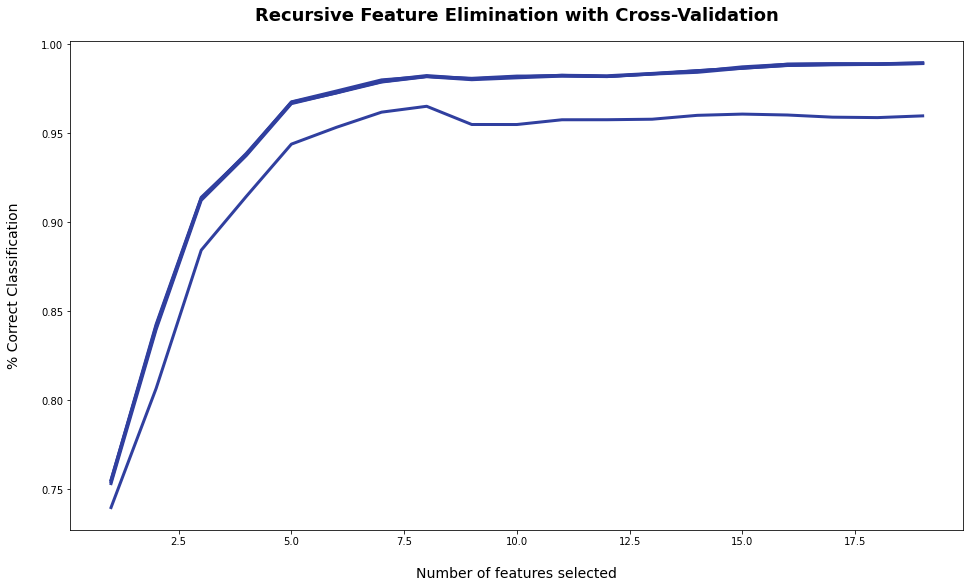

In [68]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [69]:
print(np.where(rfecv.support_ == False)[0])

os_data_X_tranformed_rfe = os_data_X_tranformed.drop(os_data_X_tranformed.columns[np.where(rfecv.support_ == False)[0]], axis=1)
os_data_X_tranformed_rfe.columns

[]


Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

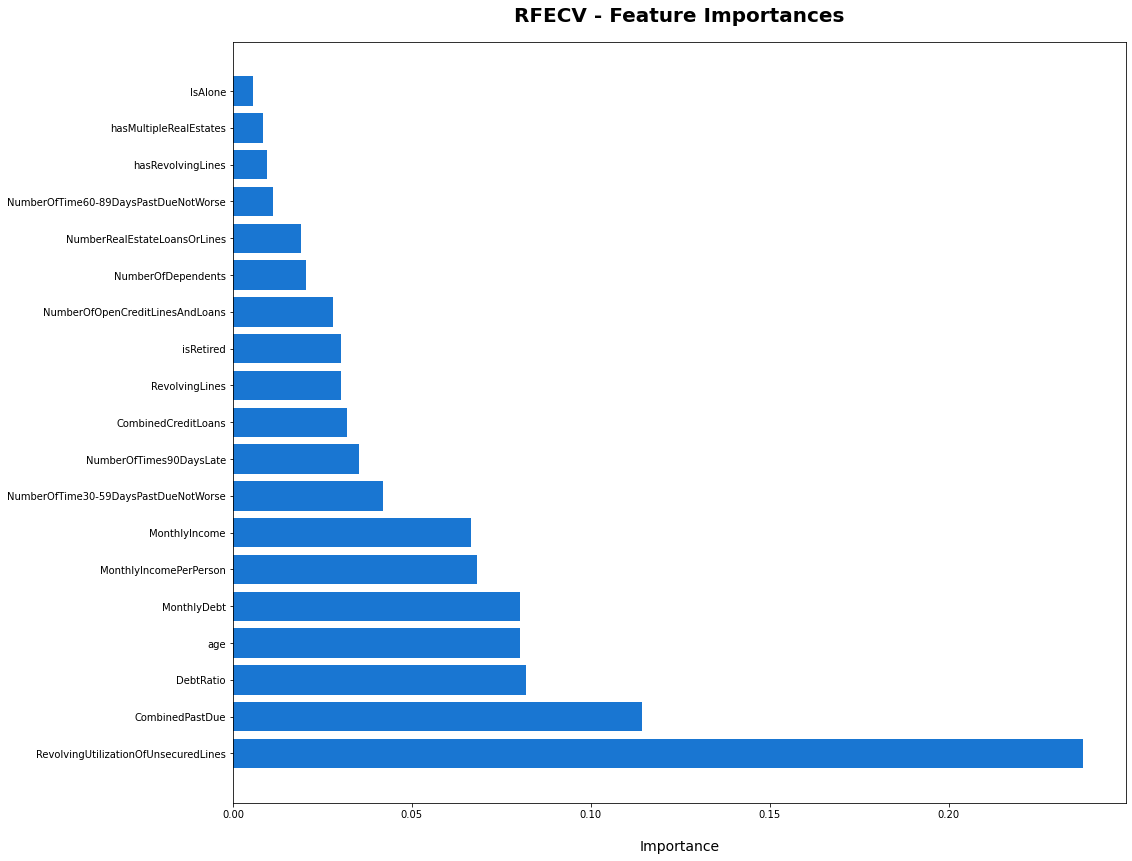

In [70]:
dset = pd.DataFrame()
dset['attr'] = os_data_X_tranformed.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

* Since our optimal performance is with the complete features and no feature is eliminated, we wil be proceeding with the complete Feature Engineered inputs

## Hypterparamter Tuning 

#### Hypter Paramter Tuning for the Random Forest, XGBoost, and LightGBM
* We will be using GridSearchCV for hyperparamater tuning

* Now we will be using Metrics such as Precision, Recall, F1 Score on class 1 only
* Previously  **macro** and **micro** were used to give idea how these 2 separate metrics are calculated

In [71]:
def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):
    
    result = []
    cols = ['Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
    
    model_name = {}
    class_str = str(classifier)
    if 'Random' in class_str:
        param_grid={
                    "n_estimators":[27,36,100,200],
                    "max_depth":[5,7,9,15],
                    "min_samples_leaf":[2,4,6,8]
        }
        model = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(4), n_jobs = -1, verbose = 2)
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)

    elif 'XG' in class_str:
        model_name = {}
        parameters = {
                      'n_estimators': [100, 200], 
                       'max_depth': [3, 5, 8], 
                       'gamma' : [0.25,0.5,1],
                       'reg_alpha': [0.1, 0.25, 0.5],
                       'reg_lambda': [0.5,1,1.15],
                        'scale_pos_weight' : [8,10,12,15]
    }
        model = GridSearchCV(classifier, parameters, scoring="neg_log_loss", cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    else:
        model_name = {}
        param_grid = {'n_estimators': [100,250,400],
                     'min_split_gain' : [0.25,0.45,0.7],
                     'max_depth': [4,7,10],
                     'subsample': [0.65,0.85],
                     'colsample_bytree': [0.45,0.65,0.85],
                     'reg_lambda': [0.5,1,3,5],
                     'num_leaves' : [30,50,70],
                     'min_data_in_leaf' : [100,400,600]
         }
        
        model = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                          cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    prec_scr, rec_scr, f1_scr, cm = cal_score(test_label, y_pred)
    result.extend([prec_scr, rec_scr, f1_scr, cm])
    series_result = pd.Series(data=result, index=cols)   
    
    return series_result, model_name

In [75]:
frame_hyperparamater = {} ; model_params = []
for key in clf_dict:
    print(key)
    if key == 'Logistic Regression':
        continue
    hyperparamater_result, model_paramters = hyperparameter_tuning(clf_dict[key], df_train, df_test,\
                                                                   y_train, y_test)
    frame_hyperparamater[key] = hyperparamater_result
    model_params.append(model_paramters)
        
tuned_df = pd.DataFrame(frame_hyperparamater)

Random Forest
XGBoost
Logistic Regression
Light GBM


### took too much Time for GridSearchCV Hyperparameter Tuning

In [78]:
model_params

[RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=15,
                        min_samples_leaf=8, n_estimators=200, random_state=42),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=1, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=200, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=42,
               reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42),
 LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
                min_split_gain=0.25, num_leaves=70, random_

In [44]:
clf_dict_balanced = {'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10}),
                       'XGBoost': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10),
                        'Logistic Regression': LogisticRegression(random_state=42, class_weight={0:1,1:10}),
                        'Light GBM': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)}

In [45]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[03:05:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:05:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:06:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:06:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Random Forest  \
Mean Accuracy                              0.899   
Accuracy deviation                         0.001   
Precision Macro                         65.45358   
Precision Micro                        89.685799   
Recall Macro                           74.935656   
Recall Micro                           89.685799   
F1 Score Macro                         68.621672   
F1 Score Micro                         89.685799   
Confusion Matrix    [[25699, 2245], [844, 1161]]   

                                         XGBoost        Logistic Regression  \
Mean Accuracy                              0.902                       0.93   
Accuracy deviation                         0.001                      0.003   
Precision Macro                        64.028085                  49.264699   
Precision Micro                        89.669104                  92.791078   
Recall Macro                           70.320185                  49.932784   
Recall Micro                           89.669104                  92.791078   
F1 Score Macro                         66.352107                   48.54321   
F1 Score Micro                         89.669104                  92.791078   
Confusion Matrix    [[25893, 2051], [1043, 962]]  [[27781, 163], [1996, 9]]   

                                       Light GBM  
Mean Accuracy                              0.845  
Accuracy deviation                         0.003  
Precision Macro                        61.734995  
Precision Micro                        84.436876  
Recall Macro                            78.16461  
Recall Micro                           84.436876  
F1 Score Macro                         64.499255  
F1 Score Micro                         84.436876  
Confusion Matrix    [[23866, 4078], [583, 1422]]

## AUCROC plot on hypertuned parameters and Model Prediction on Test Dataset

* **Plotting ROC AUC for the ML models for the original dataset**
- higher the AUC the better the Performance of the model, distingushing between positive and negative classes

In [46]:
models_balanced = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)
    }
]

[03:07:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


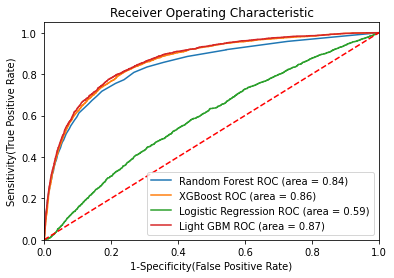

In [47]:
plot_multiplt_rocauc(models,df_train,y_train, df_test, y_test)

## * We will be going with the ***Light GBM*** model as it is performing better than the other models
* Better Recall value
* Better and more important meaningful feature
* Better Best ROC-AUC value

In [48]:
model_lgb = LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)

model_lgb.fit(df_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
               min_split_gain=0.25, num_leaves=70, random_state=42,
               reg_lambda=5, scale_pos_weight=10, subsample=0.65)

In [49]:
df_test.head()

RevolvingUtilizationOfUnsecuredLines  age  \
0                              0.019252   66   
1                              0.454221   78   
2                              0.077572   59   
3                              0.107864   59   
4                              0.101095   67   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     0   0.433926         5175.0   
1                                     0   0.873533         2300.0   
2                                     0   0.172882        10833.0   
3                                     0   0.453692         9900.0   
4                                     0   0.407831         5950.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  ...  \
0                               13                        0  ...   
1                                7                        0  ...   
2                                5                        0  ...   
3                               10                        0  ...   
4                               14                        0  ...   

   MonthlyIncomePerPerson  MonthlyDebt  isRetired  RevolvingLines  \
0             5175.000000  2245.566072          1              12   
1              766.666667  2009.126466          1               6   
2            10833.000000  1872.827120          0               4   
3             9900.000000  4491.546305          0               8   
4             5950.000000  2426.592171          1              12   

   hasRevolvingLines  hasMultipleRealEstates  IsAlone  
0                  1                       0        1  
1                  1                       0        0  
2                  1                       0        1  
3                  1                       1        1  
4                  1                       1        1  

[5 rows x 19 columns]

In [50]:
y_pred                 = model_lgb.predict(df_test)
df_test['predictions'] = y_pred

In [51]:
predict_model_lgb = lambda x: model_lgb.predict_proba(x).astype(float)

In [52]:
predict_model_lgb

<function __main__.<lambda>(x)>

### Model Save Pkl file

In [62]:
import pickle

In [63]:
filename = 'model_lgb.pkl'
pickle.dump(model_lgb, open(filename, 'wb'))


In [64]:

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred11 = loaded_model.predict(df_test)


In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_pred11)

1.0

# Model Interpretation - SHAP at a global level and LIME at a locallevel

### Feature Importance and Model Explaination using SHAP and LIME


#### **Why Interpretability in Machine Learning model is needed:**

- Fairness - We might be interested in trends of the feature wrt to target variable.
- Checking causality of features & Debugging models - We might be interested in what pattern among the features model is capturing.
- Regulations -Sometimes regulatory bodies need answers taken on model inference

* Explaining the model performance using SHAP so that black box model can become transparent one.
* **We will be looking at the model transparency using SHAP at global level and LIME at a local level**
* **
* The collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target .
    

## **SHAP(SHapely Additive exPlainations)**

#### Variable Importance Plot — Global Interpretability

In [53]:
# drop the predictions column here
df_test = df_test.drop(columns = ['predictions'])

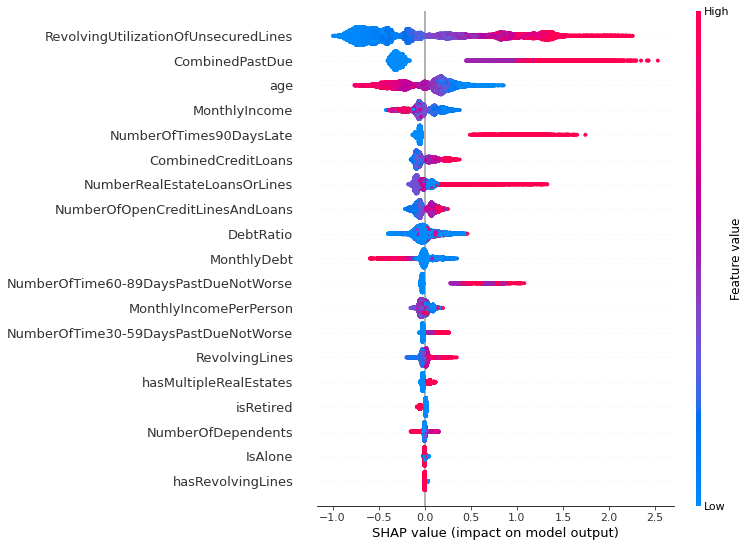

In [54]:
X_importance = df_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance)

* Feature importance: Variables are ranked in descending order.
* **
* Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* **
* Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
* **
* Correlation: A high level of the “RevolvingUtilizationOfUnsecuredLines” and "Debt Ratio" has a high and positive impact on the defaulting. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “age” is equally correlated with the target variable and non-target variable which might not give any good performance.
* "Monthly Income" effect is comparitvely low toward prediting values and even the effect is alos low

### SHAP Dependence Plot — Global Interpretability

* The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 
* The function automatically includes another variable that your chosen variable interacts most with.

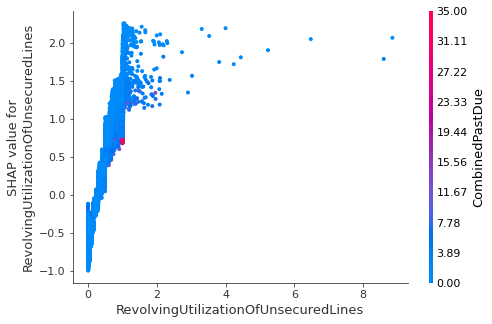

In [55]:
shap.dependence_plot("RevolvingUtilizationOfUnsecuredLines", shap_values[1], X_importance)

* The following plot shows there is an very little linear and a bit of positive trend between “RevolvingUtilizationOfUnsecuredLines” and the target variable, and “RevolvingUtilizationOfUnsecuredLines” does not interact with “CombinedPastDue”.

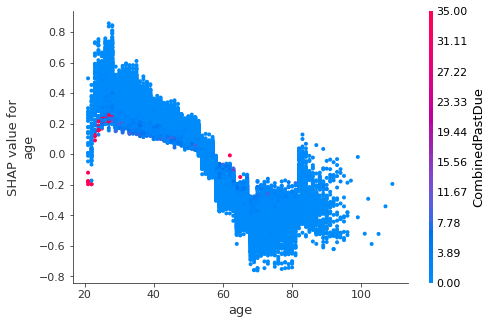

In [56]:
shap.dependence_plot("age", shap_values[1], X_importance)

* The following plot shows there is an good linear and a negative trend between “age” and the target variable, and “age” interacts with “CombinedPastDue” not so much.

## LIME(Local Interpretable Model agnostic Explanations)

* **If we want to understand how a single prediction was made for a given observation. This is where we use the LIME technique which stands for local interpretable model agnostic explanations.**

- features are globally important may not be important locally and vice versa



* Generating explainations using LIME

In [57]:
# creating the explainer function
explainer = LimeTabularExplainer(df_test.values, mode="classification", feature_names=df_test.columns)

In [58]:
exp = explainer.explain_instance(df_test.iloc[3], 
     predict_model_lgb, num_features=10)


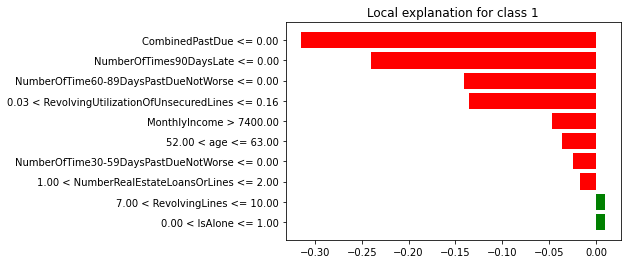

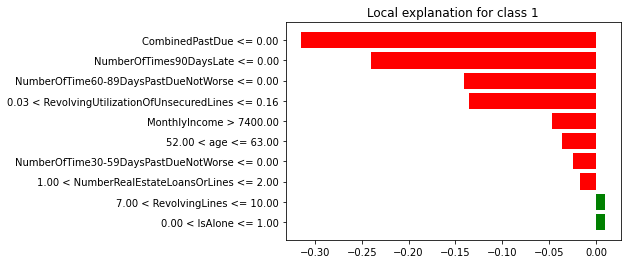

In [59]:
exp.as_pyplot_figure()

* Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
* No of times 30-59, 59-90 days and 90 days past due having no values means not missed any due date showing veryr high negative correlation with the target
* age having less values lower than 41 relatively show positive corrrelation with the target

In [60]:
# storing a new observation
i = 37
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)
        

0.43067759341161505


* Each feature’s contribution to this prediction is shown in the right bar plot. 
* Orange signifies the positive impact and blue signifies the negative impact of that feature on the target.
* For example, CombinedPastDue has a positive impact on defaulting for this row.

In [61]:
# storing a new observation
i = 25
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.42193527534666564


* Each feature’s contribution to this prediction is shown in the right bar plot. 
* Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. 
* For example, CombinedPastDue has a positive impact on non delinquency for this row which has value 0 and Monthly Income feature having value greater than 73000 contributing towards non delinquency.